In [1]:
import datetime
import os

from lhcpiv import (
    video_to_frame,  dist_to_coords, DLT_2D, resize_rgb, velocity_vectors
)

from openpiv import tools, pyprocess, validation, filters, scaling

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2

sns.set()


In [2]:
os.listdir('data/')

['IMG_1132.MOV', 'IMG_1132', 'area.csv']

In [3]:
for i in os.listdir('data/'):
    if i.endswith('MOV'):
        video_to_frame.vf('data/' + i, qty_frames=10)

Success


In [4]:
images = os.listdir('data/IMG_1132/')
images.sort()

In [5]:
images

['croped',
 'frame0.jpg',
 'frame1.jpg',
 'frame2.jpg',
 'frame3.jpg',
 'frame4.jpg',
 'frame5.jpg',
 'frame6.jpg',
 'frame7.jpg',
 'frame8.jpg',
 'frame9.jpg']

In [3]:
resize_rgb.resize('data/IMG_1132/', x1=811, y1=716, x2=1991, y2=3047, save=True)

array([[123,  90,  75, ...,  46,  52,  52],
       [155, 115, 104, ...,  53,  58,  62],
       [178, 143, 126, ...,  63,  71,  70],
       ...,
       [203, 206, 203, ...,  26,  50,  66],
       [205, 207, 205, ...,  15,  23,  39],
       [205, 204, 206, ...,  31,  16,  15]], dtype=uint8)

In [10]:
!python3 ../get_points.py --path "/data/IMG_1132/frame2.jpg"

Opening image frame2.jpg
/Users/yuriishizawa/projects/lhcpiv/src/lhcpiv/examples/data/IMG_1132/frame2.jpg
1050   2001
997   2816
436   3032
2138   2949
1442   777
749   732
1352   1678


x    y \
2098   2940 \
1430   764 \
742   718 \
444   3047

In [11]:
dist_to_coords.calculate([3, 0.89, 3.03, 1.15, 3.12, 3.21])

[(0, 0),
 (2.9686818569, 0),
 (2.9904471595, 0.8897335753),
 (-0.02838433078, 1.1496496462)]

In [12]:
xy = [
    [0, 0],
    [2.9686818569, 0],
    [2.9904471595, 0.8897335753],
    [-0.02838433078, 1.1496496462]
]

uv = [
    [2098,2940],
    [1430,764], 
    [742,718], 
    [444,3047]
]

dlt = DLT_2D.DLT_2D(xy, uv)

In [13]:
dlt.calib()

(array([ 1.78287439e+02, -1.46340221e+03,  2.09800000e+03, -5.17514202e+02,
        -1.19440782e+02,  2.94000000e+03,  2.82030161e-01, -5.85883035e-02,
         1.00000000e+00]),
 8.231152404832543e-10)

In [14]:
dlt.recon((1430,764))

array([ 2.96868186e+00, -3.09636469e-13])

In [15]:
frames = os.listdir('data/IMG_1132/croped')
frames.sort()

20211121204129.txt created successfully


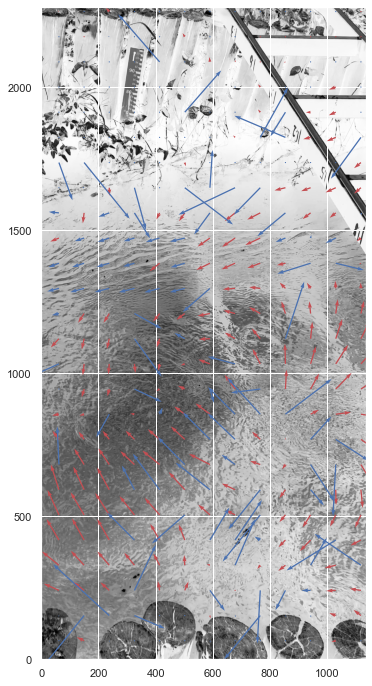

In [73]:
velocity_vectors.calculate('data/IMG_1132/croped/frame2.jpg', 'data/IMG_1132/croped/frame3.jpg', show_fig=True, arrow_length=10000, arrow_width=0.004)

In [74]:
pairs = []

for i, frame in enumerate(frames):
    if i == len(frames) - 1:
        pass
    else:
        pairs.append((frame, frames[i + 1]))


In [75]:
pairs

[('frame0.jpg', 'frame1.jpg'),
 ('frame1.jpg', 'frame2.jpg'),
 ('frame2.jpg', 'frame3.jpg'),
 ('frame3.jpg', 'frame4.jpg')]

In [76]:
cv2.imshow('croped', resize_rgb.resize('data/IMG_1132/croped/' + 'frame1.jpg',
        x1=811, x2=1991, y1=716, y2=3047))
cv2.waitKey(0)

2021-11-21 20:41:34.018 python[37193:1405606] TSM AdjustCapsLockLEDForKeyTransitionHandling - _ISSetPhysicalKeyboardCapsLockLED Auto


32

In [77]:
for frame_a, frame_b in pairs:
    velocity_vectors.calculate('data/IMG_1132/croped/' + frame_a, 
        'data/IMG_1132/croped/' + frame_b,
        save_fig=False
        )

20211121204150.txt created successfully
20211121204151.txt created successfully
20211121204151.txt created successfully
20211121204151.txt created successfully


In [78]:
def get_all_res(path):
    results_files = os.listdir(path)

    for i, file in enumerate(results_files):
        if i == 0:
            df = pd.read_csv(path + "/" + file, sep='\t')

        else:
            df_aux = pd.read_csv(path + "/" + file, sep='\t')
            df = pd.concat([df, df_aux])
    
    return df

In [82]:
df = get_all_res('piv_results')
df.columns = ['x', 'y', 'u', 'v', 'mask']


In [83]:
df['real_x'] = df.apply(lambda x: dlt.recon((x['x'],x['y']))[0], axis=1)
df['real_y'] = df.apply(lambda x: dlt.recon((x['x'],x['y']))[1], axis=1)
df['real_u'] = df.apply(lambda x: dlt.recon((x['u'],x['v']))[0], axis=1)
df['real_v'] = df.apply(lambda x: dlt.recon((x['u'],x['v']))[1], axis=1)

In [84]:
df

,x,y,u,v,mask,real_x,real_y,real_u,real_v
0,62.0,2265.0,-31.9424,27.3999,1.0,0.600507,1.460890,5.073650,2.102145
1,150.0,2265.0,-16.9808,22.0204,0.0,0.599754,1.395254,5.101877,2.082096
2,238.0,2265.0,-107.5654,121.6188,1.0,0.598997,1.329177,4.667188,2.163193
3,326.0,2265.0,-9.6505,28.3726,0.0,0.598234,1.262654,5.077157,2.067438
4,414.0,2265.0,-15.0326,36.8739,0.0,0.597465,1.195681,5.039111,2.071189
...,...,...,...,...,...,...,...,...,...
333,766.0,65.0,-1.1772,-39.3866,0.0,5.192532,0.800828,5.380660,2.091102
334,854.0,65.0,6.9526,-40.0324,0.0,5.225327,0.648855,5.386741,2.078526
335,942.0,65.0,8.9293,-40.6571,0.0,5.258618,0.494582,5.390375,2.075723
336,1030.0,65.0,117.2242,161.4933,1.0,5.292417,0.337956,4.579834,1.816566


In [87]:
df.groupby(['real_x', 'real_y']).agg({'real_v': ['mean', 'std']})

real_v          
                       mean       std
real_x   real_y                      
0.591128 0.643109  2.067575  0.007133
0.591939 0.713858  2.067994  0.007611
0.592745 0.784117  2.065684  0.009904
0.593545 0.853892  2.061633  0.006680
0.594340 0.923189  2.070059  0.005972
...                     ...       ...
5.192532 0.800828  2.082904  0.006656
5.225327 0.648855  2.076337  0.002698
5.258618 0.494582  2.073811  0.005860
5.292417 0.337956  2.188635  0.286753
5.326735 0.178924  2.070053  0.008158

[338 rows x 2 columns]

In [88]:
df[
    'real_v'
].mean()

2.4186029513909038

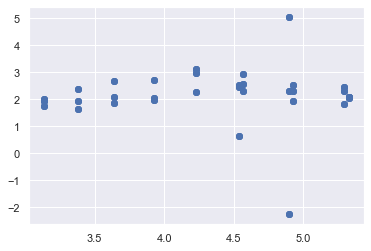

In [92]:
plt.scatter(x=df[df['real_y'] < 0.4]['real_x'], y=df[df['real_y'] < 0.4]['real_v'])